# Week 7 - Temporal models 

## Part 2: Road traffic - Time-series forecasting

In this part, we will specify a simple linear dynamical system (LDS) in STAN in order to forecast freeway occupancy rates. 

The usual imports...

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

The data consists of time-series of freeway occupancy rates (rows), with length $T=1008$, at 10 different consecutive sensors/detectors (columns). However, for now, we will focus only on the data from a single detector as an example...

Load data:

In [3]:
# load csv
df = pd.read_csv("PeMS_sample.csv")
df.head()

,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
0,0.0154,0.0054,0.0164,0.0079,0.0059,0.0138,0.0111,0.0156,0.0154,0.0080
1,0.0085,0.0051,0.0127,0.0062,0.0051,0.0125,0.0099,0.0175,0.0134,0.0067
2,0.0099,0.0056,0.0172,0.0068,0.0053,0.0116,0.0105,0.0157,0.0112,0.0065
3,0.0108,0.0045,0.0126,0.0072,0.0058,0.0131,0.0073,0.0146,0.0128,0.0040
4,0.0100,0.0037,0.0185,0.0048,0.0063,0.0099,0.0061,0.0157,0.0123,0.0064


Some basic data statistics:

In [4]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 1008
General statistics:


,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.000000
mean,0.049489,0.044541,0.066207,0.051599,0.026812,0.047976,0.037051,0.055881,0.05583,0.049262
std,0.030016,0.047490,0.047321,0.040934,0.019402,0.052455,0.036248,0.049275,0.04192,0.042152
min,0.005300,0.000000,0.000000,0.000000,0.001900,0.002200,0.002900,0.002500,0.00150,0.001500
25%,0.027150,0.014900,0.029525,0.018000,0.013100,0.014775,0.012075,0.017950,0.01820,0.027075
50%,0.055300,0.038600,0.070500,0.046400,0.021700,0.038750,0.029000,0.051500,0.05665,0.046700
75%,0.064400,0.051900,0.088025,0.070800,0.030925,0.054125,0.045400,0.069825,0.07670,0.058925
max,0.317600,0.355000,0.393600,0.232700,0.094900,0.316900,0.197200,0.307400,0.22060,0.408100


Visualize data (part of it):

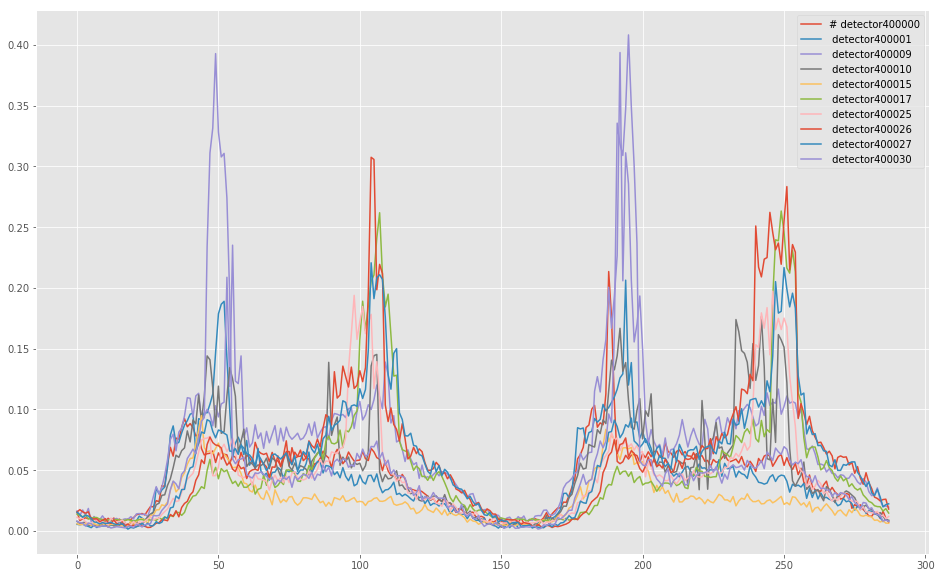

In [5]:
plt.plot(df[:(2*24*6)]); # first 2 days (2*24*6 10-minute intervals) of each of the 10 detectors
plt.legend(df.columns);

Split data into a trainset and a testset (which we wish to forecast):

In [6]:
# convert data to a matrix
y = df.values
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=1008, D=10


In [7]:
ix_train = range(6*24*6 + 20*6) # 6 days and 19 hours for training
ix_test = range(6*24*6 + 20*6, 7*24*6) # 4 hours for testing
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y[ix_train,:]
y_test = y[ix_test,:]

N_train: 984
N_test: 24


Ok, time to specify our time-series model in STAN!

For simplicty, we will start with a simple autoregressive model of order 2, AR(2), of the form:

\begin{align}
z_t &\sim \mathcal{N}(\beta_1 z_{t-1} + \beta_2 z_{t-2}, \tau^2)\\
y_t &\sim \mathcal{N}(z_t, \sigma^2)
\end{align}

Don't forget to assign reasonable priors to $\boldsymbol\beta$, $\tau$ and $\sigma$. We now also need to put priors on the first two latent states $z_1$ and $z_2$. Make sure that you understand why! What if we had an AR(5) model?

An important thing to notice, is that we need to pass an array of length $T$ as input to STAN (corresponding to observations y), where $T$ denotes the number of observations in the time-series. However, we also need to pass it a value ("T_forecast") saying the number of time-steps ahead of $T$ that we wish to forecast. 

Recall that, in order to make predictions, we need to compute the posterior for z[T:T_forecast] and y[T:T_forecast]. Therefore, we then need to propagate the dynamics described in the equations above forwards in time to T:T_forecast. In principle, this could be done either in the "model" block or in the "generated quantities" block. But, the common approach is to estimate z[T:T_forecast] in the "model" block, and then use the "generated quantities" block to generate the predicitions y[T:T_forecast].

Let's try to do it!

In [8]:
# define Stan model
model_definition = """
data {
  int<lower=1>  T; 
  int<lower=0>  T_forecast;
  real          y[T];
}
parameters{
  real          beta_1; 
  real          beta_2;
  real<lower=0> tau;
  real<lower=0> sigma;
  real          z[T + T_forecast];
}
model{
  // Priors on parameters
  beta_1 ~ normal(0, 5);
  beta_2 ~ normal(0, 5);
  tau    ~ cauchy(0, 3);
  sigma  ~ cauchy(0, 3);
  
  // Priors on initial values
  z[1] ~ normal(0, 3);
  z[2] ~ normal(0, 3);
  
  // Model
  for (t in 3:T+T_forecast){
    z[t] ~ normal(beta_1*z[t-1]+beta_2*z[t-2], tau);
  }
  for (t in 1:T){
    y[t] ~ normal(z[t], sigma);
  }
}
generated quantities{
  vector[T_forecast] y_hat;
  
  // Prediction
  for (t in 1:T_forecast){
    y_hat[t] = normal_rng(z[T+t], sigma);
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d65040df71cadadd711740df01198862 NOW.


In [9]:
T_forecast=len(ix_test)

In [10]:
# prepare data for Stan model
data = {'T': len(y_train), 'T_forecast': T_forecast, 'y': y_train[:,0]}

Compile STAN program:

Run inference using MCMC:

In [11]:
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_d65040df71cadadd711740df01198862.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_1      0.87    0.07   0.16   0.61   0.75   0.85    1.0    1.2      5   1.61
beta_2      0.12    0.07   0.16  -0.21-7.0e-3   0.14   0.24   0.37      5   1.61
tau       8.5e-3  6.0e-4 1.3e-3 6.1e-3 7.5e-3 8.6e-3 9.5e-3   0.01      5    1.6
sigma       0.01  2.0e-4 6.0e-4   0.01   0.01   0.01   0.01   0.01      9   1.27
z[1]        0.02  4.0e-4   0.01  -0.01 6.3e-3   0.02   0.02   0.04   1224    1.0
z[2]      9.5e-3  2.9e-4 9.5e-3-9.2e-3 3.3e-3 9.5e-3   0.02   0.03   1095    1.0
z[3]        0.01  2.2e-4 7.8e-3-5.5e-3 5.4e-3   0.01   0.02   0.03   1197    1.0
z[4]        0.01  2.0e-4 7.7e-3-4.9e-3 5.7e-3   0.01   0.02   0.03   1468    1.0
z[5]        0.01  2.2e-4 7.6e-3-5.1e-3 5.2e-3   0.01   0.02   0.03   1230    1.0
z[6]

Extract samples and visualize posterior over beta, tau and sigma:

In [12]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

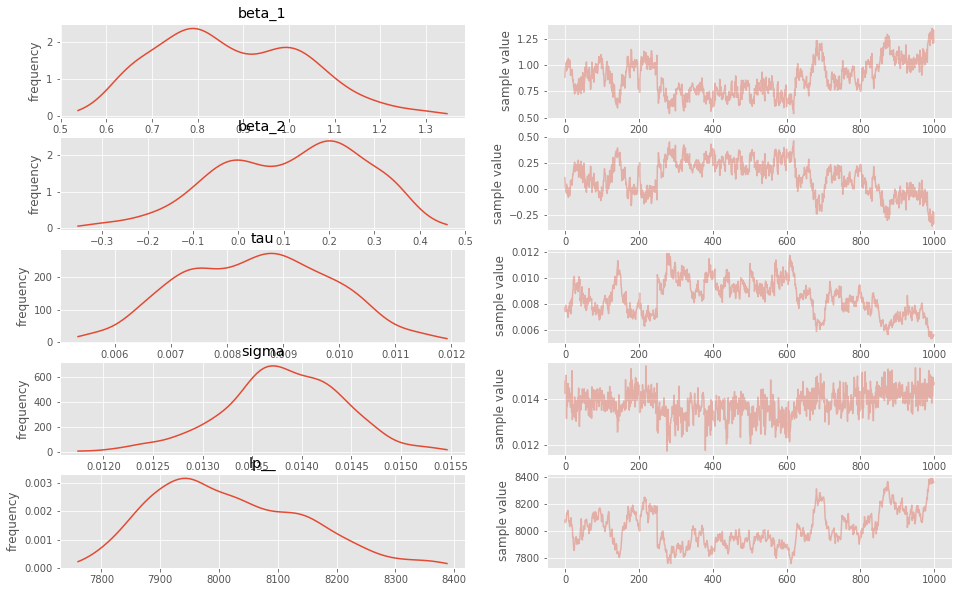

In [13]:
fit.plot(["beta_1","beta_2","tau","sigma","lp__"]);
plt.show();

Lets now look at the predictions:

In [14]:
# get mean and standard devitions for predictions
y_hat = samples["y_hat"].mean(axis=0)
y_std = samples["y_hat"].std(axis=0)

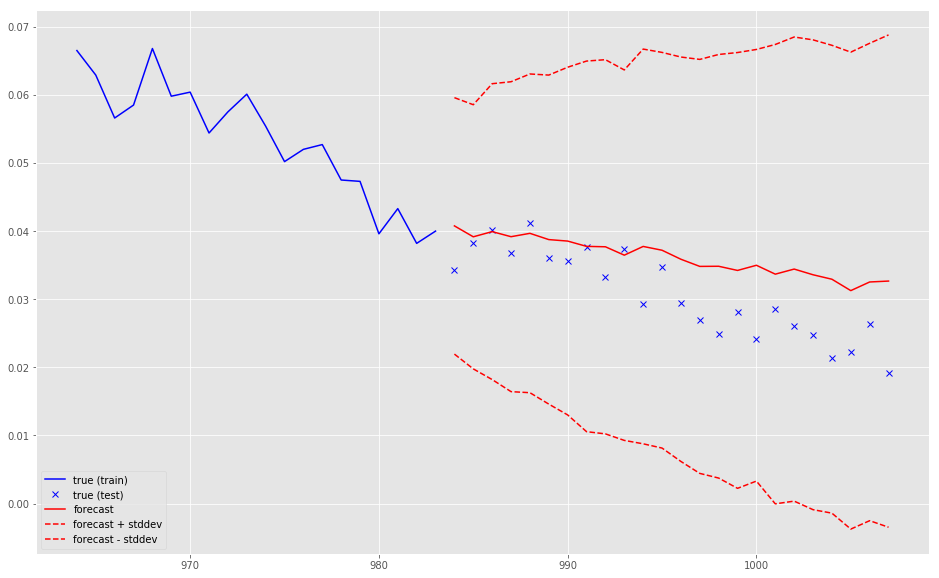

In [15]:
plt.plot(ix_train[-20:], y_train[-20:,0], "b-")
plt.plot(ix_test, y_test[:,0], "bx")
plt.plot(ix_test, y_hat, "r-")
plt.plot(ix_test, y_hat + y_std, "r--")
plt.plot(ix_test, y_hat - y_std, "r--")
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])

Did you get reasonable predictions? We should not expect amazing results, since your model is still quite simplistic...

Also, notice that in general, the predictions became worse as we move forwards in time (i.e. further away from T - the end of the blue line). This is because we are moving away from the time interval for which we have observed data (y). As a consequence, the uncertainty also increases as we move away from T. This ability to quantify the uncertainty in the predictions is a major advantage of full Bayesian approaches :-)